# Import libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Read and prepare the dataset

In [3]:
cdata = pd.read_csv('cdata.csv')
cdata = cdata.iloc[:,1:] # drop the first column which are indexes
cdata = cdata.dropna()
print(cdata.shape)
cdata.head()

(11752, 7)


,approx_loss_year,COMPANY_ID,ADR Flag,ClaimNb,SUB_REGION,Sector,RECENT_IPO
0,1990.0,1003820,False,1,United States,Industrials,False
1,1990.0,1079296,False,1,United States,Industrials,False
2,1990.0,1084455,False,1,United States,Communication Services,False
3,1991.0,1081494,False,1,United States,Consumer Discretionary,False
4,1992.0,1000676,False,1,United States,Industrials,False


In [4]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11752 entries, 0 to 11762
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   approx_loss_year  11752 non-null  float64
 1   COMPANY_ID        11752 non-null  int64  
 2   ADR Flag          11752 non-null  bool   
 3   ClaimNb           11752 non-null  int64  
 4   SUB_REGION        11752 non-null  object 
 5   Sector            11752 non-null  object 
 6   RECENT_IPO        11752 non-null  bool   
dtypes: bool(2), float64(1), int64(2), object(2)
memory usage: 573.8+ KB


In [5]:
cat_columns = ['SUB_REGION', 'ADR Flag', 'Sector', 'RECENT_IPO']
X = pd.get_dummies(cdata[cat_columns])
X['ADR Flag'] = X['ADR Flag'].astype(int)
X['RECENT_IPO'] = X['RECENT_IPO'].astype(int)
X.head()

,ADR Flag,RECENT_IPO,SUB_REGION_Africa,SUB_REGION_Canada,SUB_REGION_France,SUB_REGION_Germany,SUB_REGION_Greater Middle East,SUB_REGION_Hong Kong,SUB_REGION_Israel,SUB_REGION_Japan,...,Sector_Consumer Discretionary,Sector_Consumer Staples,Sector_Energy,Sector_Financials,Sector_Health Care,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Utilities
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
y = cdata['ClaimNb']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: ClaimNb, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
print(Xtrain.shape)
print(Xtest.shape)

(7873, 31)
(3879, 31)


In [8]:
def poisson_deviance(y_true, y_pred):
  return 2*( np.sum( y_pred ) - np.sum( y_true ) + np.sum( np.log(( y_true / y_pred )**(y_true))))/len(y_true)

In [10]:
# store results for each model
# store predictions for each model
train = pd.DataFrame()
test = pd.DataFrame()
train['ClaimNb'] = ytrain
test['ClaimNb'] = ytest

train_results = pd.DataFrame(index=['poisson deviance'])
test_results = pd.DataFrame(index=['poisson deviance'])

# Exploratory Data Analysis

In [11]:
PLOT_DIRECTORY = 'plots'
def save_figure(title):
  
  if PLOT_DIRECTORY not in os.listdir():
    os.mkdir(PLOT_DIRECTORY)
  else:
    print('Directory already exists')
  fname = title + '.png'
  path = os.path.join(PLOT_DIRECTORY, fname)
  if fname not in os.listdir(PLOT_DIRECTORY):
    plt.savefig(path)
    print('Saved!')
  else:
    print('File with same name already exists!')

Saved!


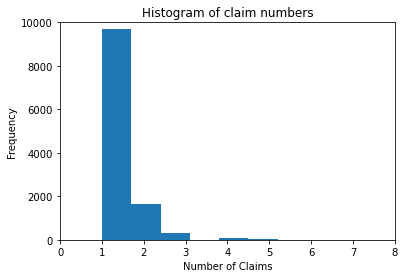

In [12]:
cdata['ClaimNb'].hist(bins=10, grid=False)
plt.ylabel('Frequency')
plt.xlabel('Number of Claims')
title = 'Histogram of claim numbers'
plt.title(title)
plt.ylim([0, 1e4])
plt.xlim([0, 8])
save_figure(title)
plt.show()

Directory already exists
Saved!


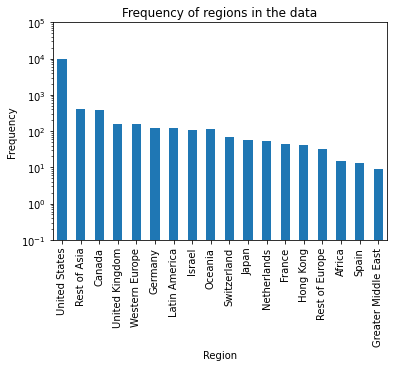

Directory already exists
Saved!


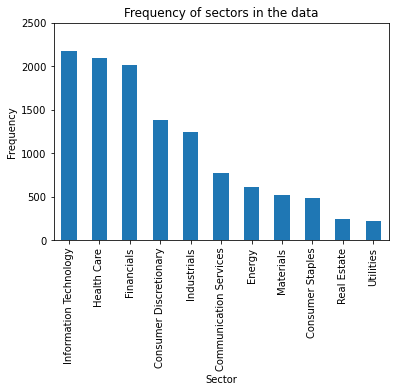

In [13]:
# Count of regions and sectors
cdata_agg_region = cdata.groupby(by='SUB_REGION').agg({'ClaimNb':['count','mean', 'sum', 'max', 'min']}).sort_values(by=[('ClaimNb','sum')], ascending=False)
cdata_agg_sector = cdata.groupby(by='Sector').agg({'ClaimNb':['count', 'mean', 'sum', 'max', 'min']}).sort_values(by=[('ClaimNb','sum')], ascending=False)
cdata_agg_adr = cdata.groupby(by='ADR Flag').agg({'ClaimNb':['count', 'mean', 'sum', 'max', 'min']}).sort_values(by=[('ClaimNb','sum')], ascending=False)
cdata_agg_ipo = cdata.groupby(by='RECENT_IPO').agg({'ClaimNb':['count', 'mean', 'sum', 'max', 'min']}).sort_values(by=[('ClaimNb','sum')], ascending=False)

cdata_agg_region.plot.bar(y=('ClaimNb','count'), legend=False)
title = 'Frequency of regions in the data'
plt.title(title)
plt.ylabel('Frequency')
plt.xlabel('Region')
plt.yscale('log')
plt.ylim([0.1, 1e5])
save_figure(title)
plt.show()

cdata_agg_sector.plot.bar(y=('ClaimNb','count'), legend=False)
title = 'Frequency of sectors in the data'
plt.title(title)
plt.ylabel('Frequency')
plt.xlabel('Sector')
plt.ylim([0, 2500])
save_figure(title)
plt.show()

Directory already exists
Saved!


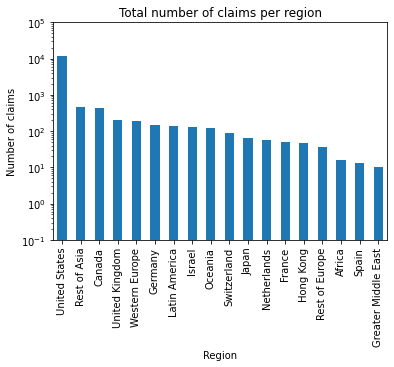

Directory already exists
Saved!


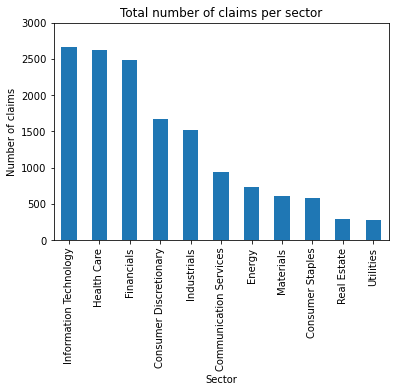

In [14]:
# TOtal number of claimns plot
# Claims per region

cdata_agg_region.plot.bar(y=('ClaimNb','sum'), legend=False)
title = 'Total number of claims per region'
plt.title(title)
plt.ylabel('Number of claims')
plt.xlabel('Region')
plt.yscale('log')
plt.ylim([0.1,1e5])
save_figure(title)
plt.show()

# Claims per sector

cdata_agg_sector.plot.bar(y=('ClaimNb','sum'), legend=False)
title = 'Total number of claims per sector'
plt.title(title)
plt.ylabel('Number of claims')
plt.xlabel('Sector')
plt.ylim([0, 3e3])
save_figure(title)
plt.show()

Directory already exists
Saved!


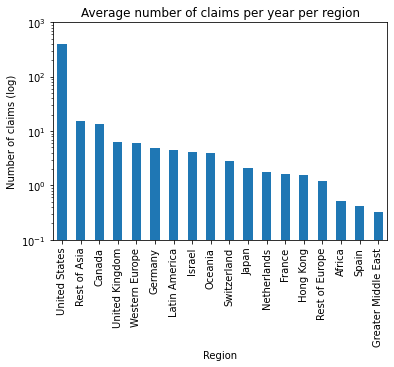

Directory already exists
Saved!


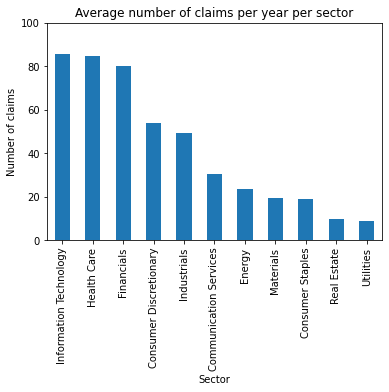

In [ ]:
num_years = cdata['approx_loss_year'].max() - cdata['approx_loss_year'].min()
(cdata_agg_region/num_years).plot.bar(y=('ClaimNb','sum'), legend=False)
title = 'Average number of claims per year per region'
plt.title(title)
plt.ylabel('Number of claims (log)')

plt.xlabel('Region')
plt.yscale('log')
plt.ylim([0.1, 1000])
save_figure(title)

plt.show()

(cdata_agg_sector/num_years).plot.bar(y=('ClaimNb','sum'), legend=False)
title ='Average number of claims per year per sector'
plt.title(title)
plt.ylabel('Number of claims')
plt.xlabel('Sector')
plt.ylim([0, 100])
save_figure(title)
plt.show()

Directory already exists
Saved!


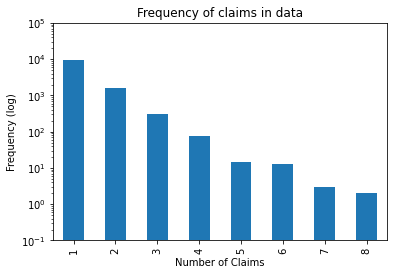

In [ ]:
(cdata.groupby('ClaimNb').count().iloc[:,0]).plot.bar()
plt.ylabel('Frequency (log)')
plt.xlabel('Number of Claims')
title = 'Frequency of claims in data'
plt.title(title)
plt.yscale('log')
plt.ylim([0.1, 1e5])
save_figure(title)
plt.show()

Directory already exists
Saved!


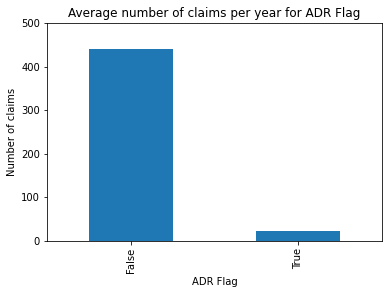

In [ ]:
# Average Number of claimns per year  for Recent IPO and ADR Flag
(cdata_agg_adr/num_years).plot.bar(y=('ClaimNb','sum'), legend=False)
title = 'Average number of claims per year for ADR Flag'
plt.title(title)
plt.ylabel('Number of claims')
plt.xlabel('ADR Flag')
plt.ylim([0, 500])
save_figure(title)
plt.show()


Directory already exists
Saved!


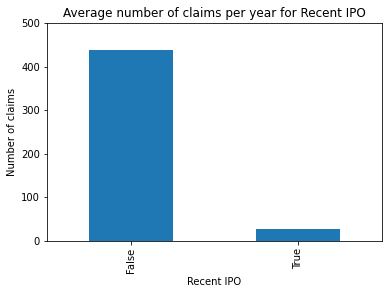

In [ ]:
(cdata_agg_ipo/num_years).plot.bar(y=('ClaimNb','sum'), legend=False)
title = 'Average number of claims per year for Recent IPO'
plt.title(title)
plt.ylabel('Number of claims')
plt.xlabel('Recent IPO')
plt.ylim([0, 500])
save_figure(title)
plt.show()

# Correlation analysis

In [ ]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7873 entries, 6659 to 7281
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   ADR Flag                        7873 non-null   int64
 1   RECENT_IPO                      7873 non-null   int64
 2   SUB_REGION_Africa               7873 non-null   uint8
 3   SUB_REGION_Canada               7873 non-null   uint8
 4   SUB_REGION_France               7873 non-null   uint8
 5   SUB_REGION_Germany              7873 non-null   uint8
 6   SUB_REGION_Greater Middle East  7873 non-null   uint8
 7   SUB_REGION_Hong Kong            7873 non-null   uint8
 8   SUB_REGION_Israel               7873 non-null   uint8
 9   SUB_REGION_Japan                7873 non-null   uint8
 10  SUB_REGION_Latin America        7873 non-null   uint8
 11  SUB_REGION_Netherlands          7873 non-null   uint8
 12  SUB_REGION_Oceania              7873 non-null   uint8
 13  

In [ ]:
from scipy.stats import pointbiserialr

def corr(var1, var2):
  return pointbiserialr(var1, var2).correlation

df2 = Xtrain.copy()
df2['ClaimNb'] = ytrain
display(df2.corr(corr))


,ADR Flag,RECENT_IPO,SUB_REGION_Africa,SUB_REGION_Canada,SUB_REGION_France,SUB_REGION_Germany,SUB_REGION_Greater Middle East,SUB_REGION_Hong Kong,SUB_REGION_Israel,SUB_REGION_Japan,...,Sector_Consumer Staples,Sector_Energy,Sector_Financials,Sector_Health Care,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Utilities,ClaimNb
ADR Flag,1.000000,0.081670,0.066310,-0.040773,0.179629,0.214886,-0.005140,0.016701,0.102244,0.217654,...,-0.016883,-0.001256,0.009235,-0.025637,0.021300,-0.040412,0.024933,-0.030511,0.008932,-0.025164
RECENT_IPO,0.081670,1.000000,0.009513,0.019944,0.021548,0.029727,-0.005505,0.004533,0.011690,0.006324,...,-0.021975,-0.008013,-0.003438,-0.000308,0.013272,-0.023736,0.000970,0.015275,-0.019383,0.009619
SUB_REGION_Africa,0.066310,0.009513,1.000000,-0.005704,-0.001939,-0.003252,-0.000719,-0.001871,-0.003042,-0.002250,...,-0.006532,-0.007320,-0.003999,-0.014768,-0.011059,-0.004887,0.070607,-0.004823,-0.004579,-0.005619
SUB_REGION_Canada,-0.040773,0.019944,-0.005704,1.000000,-0.010874,-0.018234,-0.004032,-0.010491,-0.017060,-0.012618,...,-0.003074,0.029545,0.005713,-0.009763,-0.033597,-0.037798,0.182267,-0.017127,-0.010044,-0.033467
SUB_REGION_France,0.179629,0.021548,-0.001939,-0.010874,1.000000,-0.006199,-0.001371,-0.003567,-0.005800,-0.004290,...,-0.012454,-0.013956,0.000008,0.004839,0.012785,0.003523,-0.002909,-0.009194,0.021081,-0.016781
SUB_REGION_Germany,0.214886,0.029727,-0.003252,-0.018234,-0.006199,1.000000,-0.002299,-0.005981,-0.009726,-0.007194,...,-0.014480,-0.023402,0.050119,-0.037307,0.005312,-0.029011,-0.021959,-0.015417,0.021155,-0.000310
SUB_REGION_Greater Middle East,-0.005140,-0.005505,-0.000719,-0.004032,-0.001371,-0.002299,1.000000,-0.001323,-0.002151,-0.001591,...,0.024055,-0.005175,0.004635,-0.010440,-0.007818,-0.010721,-0.004856,-0.003409,-0.003237,0.001047
SUB_REGION_Hong Kong,0.016701,0.004533,-0.001871,-0.010491,-0.003567,-0.005981,-0.001323,1.000000,-0.005596,-0.004139,...,0.021142,0.016430,-0.021018,-0.021465,-0.013322,-0.005488,0.029590,-0.008871,0.007023,-0.004048
SUB_REGION_Israel,0.102244,0.011690,-0.003042,-0.017060,-0.005800,-0.009726,-0.002151,-0.005596,1.000000,-0.006731,...,-0.005870,-0.003409,-0.025747,0.015733,-0.007034,0.034317,-0.000962,0.003752,-0.013696,0.005027
SUB_REGION_Japan,0.217654,0.006324,-0.002250,-0.012618,-0.004290,-0.007194,-0.001591,-0.004139,-0.006731,1.000000,...,-0.005249,-0.016194,0.001331,-0.013691,0.016448,-0.019558,-0.006406,0.001568,0.015592,-0.008807


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


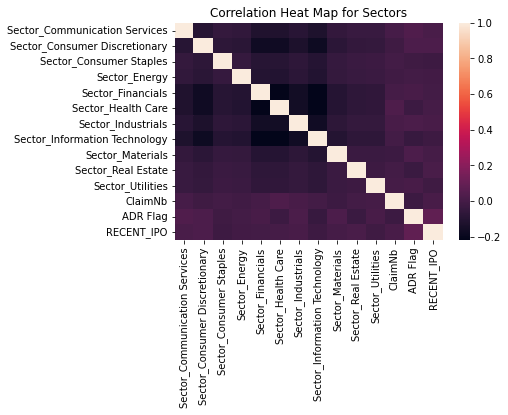

In [ ]:
df3 = df2.loc[:,df2.columns.str.startswith('Sector')]
df3['ClaimNb'] = df2['ClaimNb']
df3.loc[:,['ADR Flag','RECENT_IPO']] = df2.loc[:, ['ADR Flag','RECENT_IPO']]
sns.heatmap(df3.corr(corr))
plt.title('Correlation Heat Map for Sectors')
plt.show();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


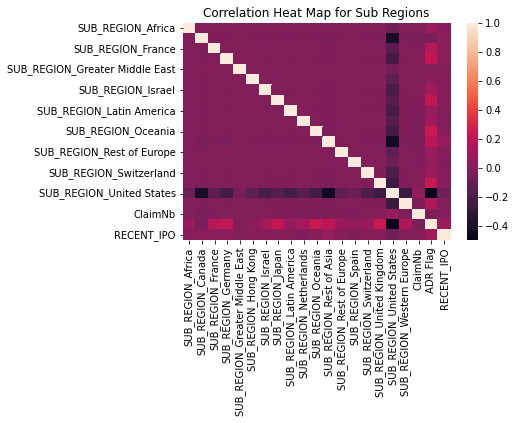

In [ ]:
df3 = df2.loc[:,df2.columns.str.startswith('SUB_REGION')]
df3['ClaimNb'] = df2['ClaimNb']
df3.loc[:,['ADR Flag','RECENT_IPO']] = df2.loc[:, ['ADR Flag','RECENT_IPO']]
sns.heatmap(df3.corr(corr))
plt.title('Correlation Heat Map for Sub Regions')
plt.show();

In [ ]:
df2.corrwith(df2['ClaimNb']).sort_values()

SUB_REGION_Oceania               -0.035896
SUB_REGION_Canada                -0.033467
SUB_REGION_Rest of Asia          -0.027821
Sector_Materials                 -0.026544
ADR Flag                         -0.025164
SUB_REGION_Netherlands           -0.020324
SUB_REGION_France                -0.016781
Sector_Consumer Discretionary    -0.016687
SUB_REGION_Spain                 -0.014917
SUB_REGION_Latin America         -0.014349
SUB_REGION_Western Europe        -0.012027
Sector_Energy                    -0.011649
SUB_REGION_Rest of Europe        -0.011127
SUB_REGION_Japan                 -0.008807
SUB_REGION_Africa                -0.005619
Sector_Information Technology    -0.004751
SUB_REGION_Hong Kong             -0.004048
Sector_Real Estate               -0.003690
Sector_Consumer Staples          -0.003436
Sector_Financials                -0.000523
SUB_REGION_Germany               -0.000310
SUB_REGION_Greater Middle East    0.001047
Sector_Utilities                  0.002244
SUB_REGION_

Text(0.5, 0, 'Number of Claims')

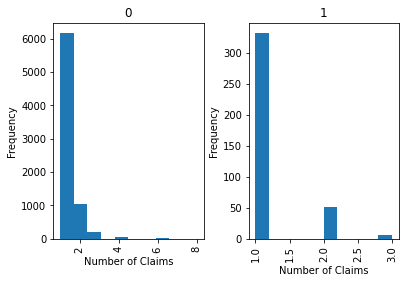

In [ ]:
axs = df2.hist('ClaimNb', by='ADR Flag');
axs[0].set_ylabel('Frequency')
axs[1].set_ylabel('Frequency')
axs[0].set_xlabel('Number of Claims')
axs[1].set_xlabel('Number of Claims')

In [ ]:
# Average number of claims for ADR Flag True and False
print(f"Average claims with ADR Flag = {cdata.loc[cdata['ADR Flag'], 'ClaimNb'].mean():.3f}")
print(f"Average claims without ADR Flag = {cdata.loc[~cdata['ADR Flag'], 'ClaimNb'].mean():.3f}")

Average claims with ADR Flag = 1.163
Average claims without ADR Flag = 1.226


# GLM

## GLM with all covariables

In [ ]:
import statsmodels.api as sm
Xtrain2 = sm.add_constant(Xtrain)

glm = sm.GLM(ytrain, Xtrain2, family=sm.families.Poisson())

glm = glm.fit()

print(glm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                 7873
Model:                            GLM   Df Residuals:                     7843
Model Family:                 Poisson   Df Model:                           29
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9104.0
Date:                Sun, 07 Aug 2022   Deviance:                       1485.1
Time:                        11:07:05   Pearson chi2:                 2.00e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
from sklearn.metrics import mean_absolute_error
Xtest2 = sm.add_constant(Xtest)


PoissonDeviance = tf.keras.metrics.poisson
train['GLM'] = glm.predict(Xtrain2)
test['GLM'] = glm.predict(Xtest2)

in_sample_loss = poisson_deviance(train['ClaimNb'], train['GLM'])
out_sample_loss = poisson_deviance(test['ClaimNb'], test['GLM'])
print(f"Poisson deviance GLM (train): {in_sample_loss :.3f}" )
print(f"Poisson deviance GLM (test): {out_sample_loss :.3f}" )

train_results['GLM'] = [in_sample_loss]
test_results['GLM'] = [out_sample_loss]

print(f"Average Observed number of claims in test data = {ytest.mean():.3f}")
print(f"Average GLM number of claims in test data = {test['GLM'].mean():.3f}")

print(f"MAE = {mean_absolute_error(ytest, test['GLM']):.3f}")

Poisson deviance GLM (train): 0.189
Poisson deviance GLM (test): 0.191
Average Observed number of claims in test data = 1.222
Average GLM number of claims in test data = 1.224
MAE = 0.367


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Test case

In [ ]:
# How often does a claim occur in a year for an airline company in the US, no recent IPO
test_sample = pd.DataFrame([[0]*len(Xtrain.columns)],columns=Xtrain.columns)
test_sample['const'] = 1
test_sample['SUB_REGION_United States'] = 1
test_sample['Sector_Industrials'] = 1
test_sample['RECENT_IPO'] = 1
glm.predict(test_sample)

0    1.166608
dtype: float64

## GLM just with sectors

In [ ]:
Xtrain3 = Xtrain.loc[:, Xtrain.columns.str.contains('Sector')]
Xtest3 = Xtest.loc[:, Xtest.columns.str.contains('Sector')]
if 'const' not in Xtrain3.columns:
  Xtrain3 = sm.add_constant(Xtrain3)
if 'const' not in Xtest3.columns:
  Xtest3 = sm.add_constant(Xtest3)
Xtrain3.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,Sector_Communication Services,Sector_Consumer Discretionary,Sector_Consumer Staples,Sector_Energy,Sector_Financials,Sector_Health Care,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Utilities
6659,1.0,0,0,0,0,0,0,0,1,0,0,0
9129,1.0,0,0,0,0,0,0,0,1,0,0,0
6724,1.0,0,0,0,0,1,0,0,0,0,0,0
1593,1.0,0,0,0,0,0,0,0,1,0,0,0
7292,1.0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
import statsmodels.api as sm

glm_sectors = sm.GLM(ytrain, Xtrain3, family=sm.families.Poisson())

glm_sectors = glm_sectors.fit()

print(glm_sectors.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                 7873
Model:                            GLM   Df Residuals:                     7862
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9109.0
Date:                Sun, 07 Aug 2022   Deviance:                       1495.2
Time:                        11:11:27   Pearson chi2:                 2.02e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [ ]:
from sklearn.metrics import mean_absolute_error

PoissonDeviance = tf.keras.metrics.poisson
train['GLM Sectors'] = glm_sectors.predict(Xtrain3)
test['GLM Sectors'] = glm_sectors.predict(Xtest3)

in_sample_loss = poisson_deviance(train['ClaimNb'], train['GLM Sectors'])
out_sample_loss = poisson_deviance(test['ClaimNb'], test['GLM Sectors'])
print(f"Poisson deviance GLM (train): {in_sample_loss :.3f}" )
print(f"Poisson deviance GLM (test): {out_sample_loss :.3f}" )

train_results['GLM Sectors'] = [in_sample_loss]
test_results['GLM Sectors'] = [out_sample_loss]

print(f"Average Observed number of claims in test data = {ytest.mean():.3f}")
print(f"Average GLM number of claims in test data = {test['GLM Sectors'].mean():.3f}")

print(f"MAE = {mean_absolute_error(ytest, test['GLM Sectors']):.3f}")

Poisson deviance GLM (train): 0.190
Poisson deviance GLM (test): 0.192
Average Observed number of claims in test data = 1.222
Average GLM number of claims in test data = 1.224
MAE = 0.368


# Neural Networks

In [ ]:
q0 = Xtrain.shape[1] # number of input features
q1 = 100  # number of neurons in hidden layer

In [ ]:
lambda_hom = sum(ytrain)/len(ytrain)
lambda_hom

1.2239298869554172

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(q1, input_shape=(q0,), activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='linear', kernel_initializer=tf.keras.initializers.Constant(tf.math.log(lambda_hom)), bias_initializer=tf.keras.initializers.Zeros()))
model.add(tf.keras.layers.Dense(1, activation='exponential', trainable=True, kernel_initializer=tf.keras.initializers.Ones(),
    bias_initializer=tf.keras.initializers.Zeros()))

In [ ]:
model.compile(loss='poisson', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3200      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 3,303
Trainable params: 3,303
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 300
batch_size = 1000
validation_split = 0.2  # set to >0 to see train/validation loss in plot(fit)
verbose = 1

In [ ]:
history = model.fit(Xtrain, ytrain, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)

Epoch 1/300
7/7 [==============================] - 1s 40ms/step - loss: 1.0516 - mse: 0.5090 - val_loss: 1.0064 - val_mse: 0.3953
Epoch 2/300
7/7 [==============================] - 0s 8ms/step - loss: 0.9991 - mse: 0.3946 - val_loss: 0.9852 - val_mse: 0.3208
Epoch 3/300
7/7 [==============================] - 0s 9ms/step - loss: 0.9810 - mse: 0.3333 - val_loss: 0.9798 - val_mse: 0.3013
Epoch 4/300
7/7 [==============================] - 0s 9ms/step - loss: 0.9795 - mse: 0.3270 - val_loss: 0.9790 - val_mse: 0.2993
Epoch 5/300
7/7 [==============================] - 0s 13ms/step - loss: 0.9770 - mse: 0.3217 - val_loss: 0.9784 - val_mse: 0.2985
Epoch 6/300
7/7 [==============================] - 0s 10ms/step - loss: 0.9767 - mse: 0.3209 - val_loss: 0.9775 - val_mse: 0.2961
Epoch 7/300
7/7 [==============================] - 0s 10ms/step - loss: 0.9760 - mse: 0.3191 - val_loss: 0.9773 - val_mse: 0.2956
Epoch 8/300
7/7 [==============================] - 0s 9ms/step - loss: 0.9766 - mse: 0.3207 -

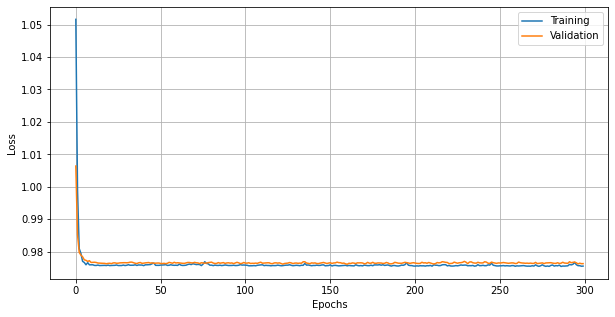

In [ ]:
import matplotlib.pyplot as plt
def plot_training(history):
  plt.figure(figsize=(10,5))
  plt.plot(history.history['loss'] ,label='Training')
  plt.plot(history.history['val_loss'], label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend();

plot_training(history)

In [ ]:
PoissonDeviance = tf.keras.metrics.poisson

train['shNN'] = model.predict(Xtrain)
test['shNN'] = model.predict(Xtest)

in_sample_loss = poisson_deviance(train['ClaimNb'], train['shNN'])
out_sample_loss = poisson_deviance(test['ClaimNb'], test['shNN'])
print(f"Poisson deviance shallow network (train): {in_sample_loss :.3f}" )
print(f"Poisson deviance shallow network (test): {out_sample_loss :.3f}" )

train_results['shNN'] = [in_sample_loss]
test_results['shNN'] = [out_sample_loss]

Poisson deviance shallow network (train): 0.188
Poisson deviance shallow network (test): 0.192


In [ ]:
shNN_frequency = sum(test['shNN']) / len(test)
print(f"Average frequency (test): {shNN_frequency: .3f}" )

Average frequency (test):  1.229


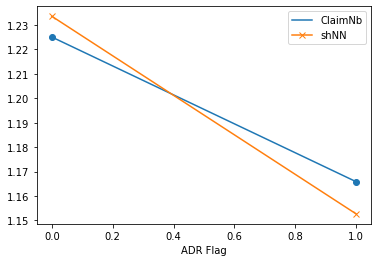

In [ ]:
plot_df = Xtest.copy()
plot_df['ClaimNb'] = test['ClaimNb']
plot_df['shNN'] = test['shNN']

grouped_data = plot_df.groupby(by=['ADR Flag']).mean()
ax = grouped_data.plot(y='ClaimNb', marker='o')
grouped_data.plot(y='shNN', marker='x', ax=ax);

#grouped_data = plot_df.groupby(by=['R2','R3']).mean()
#ax2 = grouped_data.plot(y='ClaimNb', marker='o')
#grouped_data.plot(y='shNN', marker='x', ax=ax2);

# Deep vanillha neural network

In [ ]:
# define network
q0 = Xtrain.shape[1]   # dimension of features
q1 = 20                 # number of neurons in first hidden layer
q2 = 15                 # number of neurons in second hidden layer
q3 = 10                 # number of neurons in second hidden layer

print("Neural network with K=3 hidden layer")

Neural network with K=3 hidden layer


In [ ]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(q1, input_shape=(q0,), activation='tanh'))
model2.add(tf.keras.layers.Dense(q2, activation='tanh'))
model2.add(tf.keras.layers.Dense(q3, activation='tanh'))
model2.add(tf.keras.layers.Dense(1, activation='linear', kernel_initializer=tf.keras.initializers.Constant(tf.math.log(lambda_hom)), bias_initializer=tf.keras.initializers.Zeros()))
model2.add(tf.keras.layers.Dense(1, activation='exponential', trainable=False, kernel_initializer=tf.keras.initializers.Ones(),
    bias_initializer=tf.keras.initializers.Zeros()))

In [ ]:
model2.compile(loss='poisson', optimizer='nadam', metrics=['mse'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                640       
                                                                 
 dense_4 (Dense)             (None, 15)                315       
                                                                 
 dense_5 (Dense)             (None, 10)                160       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
Total params: 1,128
Trainable params: 1,126
Non-trainable params: 2
_________________________________________________________________


In [ ]:
epochs = 30
batch_size = 1000
validation_split = 0.2  # set to >0 to see train/validation loss in plot(fit)
verbose = 1

In [ ]:
history = model2.fit(Xtrain, ytrain, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)

Epoch 1/30
7/7 [==============================] - 0s 9ms/step - loss: 0.9756 - mse: 0.3182 - val_loss: 0.9765 - val_mse: 0.2938
Epoch 2/30
7/7 [==============================] - 0s 10ms/step - loss: 0.9756 - mse: 0.3183 - val_loss: 0.9765 - val_mse: 0.2937
Epoch 3/30
7/7 [==============================] - 0s 10ms/step - loss: 0.9756 - mse: 0.3181 - val_loss: 0.9766 - val_mse: 0.2939
Epoch 4/30
7/7 [==============================] - 0s 12ms/step - loss: 0.9756 - mse: 0.3182 - val_loss: 0.9769 - val_mse: 0.2947
Epoch 5/30
7/7 [==============================] - 0s 12ms/step - loss: 0.9756 - mse: 0.3182 - val_loss: 0.9765 - val_mse: 0.2937
Epoch 6/30
7/7 [==============================] - 0s 9ms/step - loss: 0.9755 - mse: 0.3181 - val_loss: 0.9765 - val_mse: 0.2937
Epoch 7/30
7/7 [==============================] - 0s 10ms/step - loss: 0.9756 - mse: 0.3181 - val_loss: 0.9765 - val_mse: 0.2938
Epoch 8/30
7/7 [==============================] - 0s 10ms/step - loss: 0.9756 - mse: 0.3182 - val_l

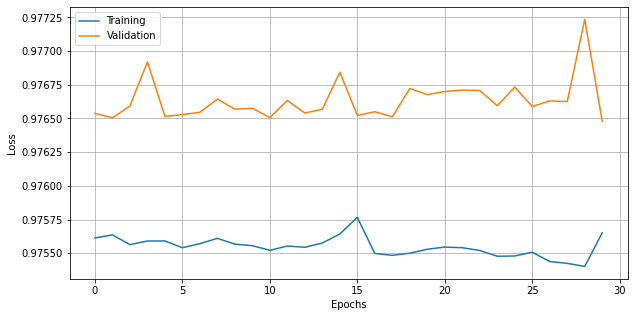

In [ ]:
plot_training(history)

In [ ]:
PoissonDeviance = tf.keras.metrics.poisson

train['dpNN'] = model2.predict(Xtrain)
test['dpNN'] = model2.predict(Xtest)

in_sample_loss = poisson_deviance(train['ClaimNb'], train['shNN'])
out_sample_loss = poisson_deviance(test['ClaimNb'], test['shNN'])
print(f"Poisson deviance shallow network (train): {in_sample_loss :.3f}" )
print(f"Poisson deviance shallow network (test): {out_sample_loss :.3f}" )

train_results['dpNN'] = [in_sample_loss]
test_results['dpNN'] = [out_sample_loss]

Poisson deviance shallow network (train): 0.188
Poisson deviance shallow network (test): 0.192


In [ ]:
dpNN_frequency = sum(test['dpNN']) / len(test)
print(f"Average frequency (test): {dpNN_frequency: .3f}" )

Average frequency (test):  1.218


 # Deep neural network with dropout layers

In [ ]:
q0 = Xtrain.shape[1]   # dimension of features
q1 = 20                 # number of neurons in first hidden layer
q2 = 15                 # number of neurons in second hidden layer
q3 = 10                 # number of neurons in second hidden layer
p0 = 0.05               # dropout rate     

In [ ]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Dense(q1, input_shape=(q0,), activation='tanh'))
model3.add(tf.keras.layers.Dropout(p0))
model3.add(tf.keras.layers.Dense(q2, activation='tanh'))
model3.add(tf.keras.layers.Dropout(p0))
model3.add(tf.keras.layers.Dense(q3, activation='tanh'))
model3.add(tf.keras.layers.Dropout(p0))
model3.add(tf.keras.layers.Dense(1, activation='linear', kernel_initializer=tf.keras.initializers.Constant(tf.math.log(lambda_hom)), bias_initializer=tf.keras.initializers.Zeros()))
model3.add(tf.keras.layers.Dense(1, activation='exponential', trainable=False, kernel_initializer=tf.keras.initializers.Ones(),
    bias_initializer=tf.keras.initializers.Zeros()))

In [ ]:
model3.compile(loss='poisson', optimizer='nadam', metrics=['mse'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                640       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 15)                315       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                160       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [ ]:
epochs = 30
batch_size = 1000
validation_split = 0.2  # set to >0 to see train/validation loss in plot(fit)
verbose = 1

In [ ]:
history = model3.fit(Xtrain, ytrain, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)

Epoch 1/30
7/7 [==============================] - 2s 54ms/step - loss: 0.9935 - mse: 0.3562 - val_loss: 0.9823 - val_mse: 0.3068
Epoch 2/30
7/7 [==============================] - 0s 15ms/step - loss: 0.9831 - mse: 0.3353 - val_loss: 0.9786 - val_mse: 0.2985
Epoch 3/30
7/7 [==============================] - 0s 16ms/step - loss: 0.9808 - mse: 0.3303 - val_loss: 0.9777 - val_mse: 0.2964
Epoch 4/30
7/7 [==============================] - 0s 21ms/step - loss: 0.9799 - mse: 0.3285 - val_loss: 0.9772 - val_mse: 0.2953
Epoch 5/30
7/7 [==============================] - 0s 16ms/step - loss: 0.9792 - mse: 0.3269 - val_loss: 0.9769 - val_mse: 0.2946
Epoch 6/30
7/7 [==============================] - 0s 19ms/step - loss: 0.9798 - mse: 0.3282 - val_loss: 0.9768 - val_mse: 0.2944
Epoch 7/30
7/7 [==============================] - 0s 13ms/step - loss: 0.9781 - mse: 0.3240 - val_loss: 0.9767 - val_mse: 0.2942
Epoch 8/30
7/7 [==============================] - 0s 13ms/step - loss: 0.9784 - mse: 0.3247 - val

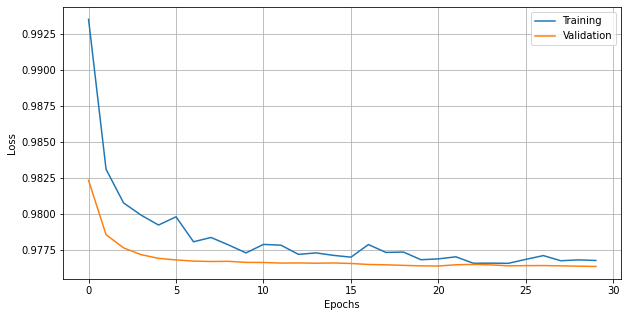

In [ ]:
plot_training(history)

(0.0, 10.0)

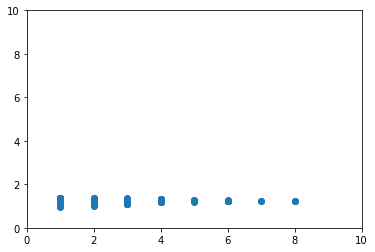

In [ ]:
plt.plot(train['ClaimNb'], train['shNN'],'o')
plt.xlim([0,10])
plt.ylim([0,10])

In [ ]:
PoissonDeviance = tf.keras.metrics.poisson

train['drNN'] = model3.predict(Xtrain)
test['drNN'] = model3.predict(Xtest)

in_sample_loss = poisson_deviance(train['ClaimNb'], train['shNN'])
out_sample_loss = poisson_deviance(test['ClaimNb'], test['shNN'])
print(f"Poisson deviance shallow network (train): {in_sample_loss :.3f}" )
print(f"Poisson deviance shallow network (test): {out_sample_loss :.3f}" )

train_results['drNN'] = [in_sample_loss]
test_results['drNN'] = [out_sample_loss]

Poisson deviance shallow network (train): 0.188
Poisson deviance shallow network (test): 0.192


In [ ]:
drNN_frequency = sum(test['drNN']) / len(test)
print(f"Average frequency (test): {drNN_frequency: .3f}" )

Average frequency (test):  1.222


# MOdel comparison


In [ ]:
# In sample performance
pd.DataFrame(train_results)

,GLM,GLM Sectors,shNN,dpNN,drNN
poisson deviance,0.188632,0.189917,0.188318,0.188318,0.188318


In [ ]:
# Out of sample performance
pd.DataFrame(test_results)

,GLM,GLM Sectors,shNN,dpNN,drNN
poisson deviance,0.191473,0.191567,0.19182,0.19182,0.19182


In [ ]:
import re
text = "On January 4, 2008, Millipore Corporation, Inc. of Billerca, MA (Millipore) has remitted $1,000 on behalf of itself and two of its subsidiaries to settle allegations of violations of the Iranian Transactions Regulations (ITR).  <P> <P>The alleged violations occurred between May and September 2005 and prior to the July 2006 acquisition of the two subsidiaries by Millipore.  <P> <P>The Office of Foreign Assets Control (OFAC) alleged that scientific samples were exported to Iran without an OFAC license.  <P> <P>Millipore voluntarily disclosed this matter to OFAC and has instituted a comprehensive U.S. sanctions compliance program."
filtered = list(filter(lambda sentence: 'Millipore' in sentence and ('$' in sentence or 'USD' in sentence), text.split('.')))
re.findall('[0-9]+\,[0-9]+', filtered[0])

['1,000']

In [ ]:
filtered[0]

' of Billerca, MA (Millipore) has remitted $1,000 on behalf of itself and two of its subsidiaries to settle allegations of violations of the Iranian Transactions Regulations (ITR)'